In [ ]:
%pip install tensorflow
%pip install numpy
%pip install transformers

     |████████████████████████████████| 462 kB 10.0 MB/s 
     |████████████████████████████████| 3.5 MB 8.1 MB/s 
     |████████████████████████████████| 895 kB 20.0 MB/s 
     |████████████████████████████████| 6.8 MB 37.4 MB/s 
     |████████████████████████████████| 596 kB 33.7 MB/s 
     |████████████████████████████████| 67 kB 4.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt

import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla K80


In [ ]:
# set environment as googledrive to folder "resource"
from google.colab import drive

data_path =  "/atis/"

try:
    drive.mount('/content/drive')
    data_path = "/content/drive/MyDrive/atis/"

except:
    print("You are not working in Colab at the moment :(")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
col_names = ["type","text","category"]
df_acid = pd.read_csv("drive/MyDrive/acidData/alldata.csv",names=col_names, header=None)
df_acid

,type,text,category
0,clinc150,"in spanish, meet me tomorrow is said how",translate
1,clinc150,"in french, how do i say, see you later",translate
2,clinc150,how do you say hello in japanese,translate
3,clinc150,how do i ask about the weather in chinese,translate
4,clinc150,how can i say cancel my order in french,translate
...,...,...,...
75533,xliuhw-bench,"that's cool, musch appreciated, olly.",general.praise
75534,xliuhw-bench,"you are hero, appreciated.",general.praise
75535,xliuhw-bench,"thanks, that's nice.",general.praise
75536,xliuhw-bench,"that's cool, thank you so much.",general.praise


In [ ]:
df_acid["type"].value_counts()

xliuhw-bench            25716
clinc150                22500
snips-bench-2017cie     13784
polyai-tsd-banking77    13081
sebis-eval-chatbot        206
sebis-eval-askubuntu      162
sebis-eval-webapps         89
Name: type, dtype: int64

In [ ]:
df_counts = df_acid["category"].value_counts()
df_counts = df_counts.to_dict()
len(df_counts)
#total 315


315

In [ ]:
df_acid.drop('type', axis=1, inplace=True)


In [ ]:
df_acid


,text,category
0,"in spanish, meet me tomorrow is said how",translate
1,"in french, how do i say, see you later",translate
2,how do you say hello in japanese,translate
3,how do i ask about the weather in chinese,translate
4,how can i say cancel my order in french,translate
...,...,...
75533,"that's cool, musch appreciated, olly.",general.praise
75534,"you are hero, appreciated.",general.praise
75535,"thanks, that's nice.",general.praise
75536,"that's cool, thank you so much.",general.praise


In [ ]:
df_acid_labels = LabelEncoder().fit_transform(df_acid["category"])
df_acid_labels

array([282, 282, 282, ..., 133, 133, 133])

In [ ]:
df_acid["category"] = df_acid_labels
df_acid = df_acid.dropna()
df_acid

,text,category
0,"in spanish, meet me tomorrow is said how",282
1,"in french, how do i say, see you later",282
2,how do you say hello in japanese,282
3,how do i ask about the weather in chinese,282
4,how can i say cancel my order in french,282
...,...,...
75533,"that's cool, musch appreciated, olly.",133
75534,"you are hero, appreciated.",133
75535,"thanks, that's nice.",133
75536,"that's cool, thank you so much.",133


In [ ]:
df_acid

,text,category
0,"in spanish, meet me tomorrow is said how",282
1,"in french, how do i say, see you later",282
2,how do you say hello in japanese,282
3,how do i ask about the weather in chinese,282
4,how can i say cancel my order in french,282
...,...,...
75533,"that's cool, musch appreciated, olly.",133
75534,"you are hero, appreciated.",133
75535,"thanks, that's nice.",133
75536,"that's cool, thank you so much.",133


In [ ]:
from sklearn.model_selection import train_test_split

train_acid, test_acid = train_test_split(df_acid, test_size=0.2)  #shuffled

In [ ]:
train_texts = train_acid["text"].tolist()
train_labels = train_acid["category"].tolist()

test_texts = test_acid["text"].tolist()
test_labels = test_acid["category"].tolist()

In [ ]:
number_of_categories = len(set(train_labels))
number_of_categories

316

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
sentences = train_texts
max_len = 250


In [ ]:
len(train_texts)

60343

In [ ]:
len(test_texts)

15086

In [ ]:
input_ids = []
attention_masks = []

for text in train_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                    
                        add_special_tokens = True,
                        max_length = max_len,      
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train_labels)

print('Original: ', train_texts[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Alexa, today I had a lunch with my longtime sweetheart. Play me a nice song to the mood.
Token IDs: tensor([  101, 24969,  1010,  2651,  1045,  2018,  1037,  6265,  2007,  2026,
        11155, 12074,  1012,  2377,  2033,  1037,  3835,  2299,  2000,  1996,
         6888,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   

In [ ]:

train_dataset = TensorDataset(input_ids, attention_masks, labels)

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

number_of_categories = len(set(train_labels))

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = number_of_categories, 
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
epochs = 4

optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8 
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)



/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 1903

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        output = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels)
        loss = output['loss']
        logits = output['logits']
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Batch    10  of  1,886.    Elapsed: 0:00:25.
Batch    20  of  1,886.    Elapsed: 0:00:50.
Batch    30  of  1,886.    Elapsed: 0:01:15.
Batch    40  of  1,886.    Elapsed: 0:01:40.
Batch    50  of  1,886.    Elapsed: 0:02:05.
Batch    60  of  1,886.    Elapsed: 0:02:30.
Batch    70  of  1,886.    Elapsed: 0:02:55.
Batch    80  of  1,886.    Elapsed: 0:03:20.
Batch    90  of  1,886.    Elapsed: 0:03:45.
Batch   100  of  1,886.    Elapsed: 0:04:10.
Batch   110  of  1,886.    Elapsed: 0:04:35.
Batch   120  of  1,886.    Elapsed: 0:05:00.
Batch   130  of  1,886.    Elapsed: 0:05:25.
Batch   140  of  1,886.    Elapsed: 0:05:50.
Batch   150  of  1,886.    Elapsed: 0:06:15.
Batch   160  of  1,886.    Elapsed: 0:06:40.
Batch   170  of  1,886.    Elapsed: 0:07:05.
Batch   180  of  1,886.    Elapsed: 0:07:29.
Batch   190  of  1,886.    Elapsed: 0:07:54.
Batch   200  of  1,886.    Elapsed: 0:08:19.
Batch   210  of  1,886.    Elapsed: 0:08:44.
Batch   220  of  1,886.  

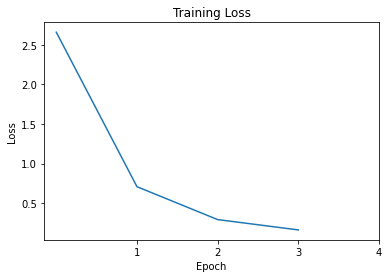

In [ ]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4])
plt.show()

In [ ]:
test_texts = test_texts
test_labels = test_labels

input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('Prediction completed')

prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

Prediction started on test data
Prediction completed


In [ ]:
f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')

print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)


F-Score:  0.9304128464585665
Recall:  0.930194805194805
Precision:  0.9332023654036132


In [ ]:

train_labels_ = banking_train_labels
train_labels_encodded = LabelEncoder().fit_transform(train_labels_)


In [ ]:
dictionary = dict(zip( train_labels_encodded,train_labels_))
print(dictionary)

{12: 'card_arrival', 14: 'card_linking', 33: 'exchange_rate', 18: 'card_payment_wrong_exchange_rate', 35: 'extra_charge_on_statement', 47: 'pending_cash_withdrawal', 37: 'fiat_currency_support', 13: 'card_delivery_estimate', 5: 'automatic_top_up', 15: 'card_not_working', 34: 'exchange_via_app', 42: 'lost_or_stolen_card', 2: 'age_limit', 50: 'pin_blocked', 24: 'contactless_not_working', 56: 'top_up_by_bank_transfer_charge', 48: 'pending_top_up', 9: 'cancel_transfer', 60: 'top_up_limits', 75: 'wrong_amount_of_cash_received', 16: 'card_payment_fee_charged', 66: 'transfer_not_received_by_recipient', 54: 'supported_cards_and_currencies', 41: 'getting_virtual_card', 11: 'card_acceptance', 61: 'top_up_reverted', 7: 'balance_not_updated_after_cheque_or_cash_deposit', 17: 'card_payment_not_recognised', 31: 'edit_personal_details', 74: 'why_verify_identity', 68: 'unable_to_verify_identity', 39: 'get_physical_card', 73: 'visa_or_mastercard', 62: 'topping_up_by_card', 30: 'disposable_card_limits',

In [ ]:

report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))
report = report.rename(columns=dictionary)

print(report)

                   0          1     2  ...  accuracy    macro avg  weighted avg
precision   1.000000   1.000000   1.0  ...  0.930195     0.933202      0.933202
recall      0.975000   0.975000   1.0  ...  0.930195     0.930195      0.930195
f1-score    0.987342   0.987342   1.0  ...  0.930195     0.930413      0.930413
support    40.000000  40.000000  40.0  ...  0.930195  3080.000000   3080.000000

[4 rows x 80 columns]
